***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

DONE loading MixUp Data generator


# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\GitHub Repo\HDeep_CapsNet\code\Training_and_Analysis\1_EMNIST
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "4" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  4
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Import Dataset : EMNIST

In [4]:
dataset = datasets.E_MNIST(version = 'ALL') # importing Dataset
num_fine  = 47

EMNIST dataset: Training have 112,800 samples and testing have 18,800 samples


# Parameters

In [5]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [6]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [7]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [8]:
coarse_to_fine_array = np.zeros(shape=[number_of_classes_c,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_train_fine'])):
    coarse_to_fine_array[c_id[x]][f_id[x]] = 1

Matrix_coarse_to_fine_OneHot = tf.constant(coarse_to_fine_array, dtype=tf.float32)

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss

def CustomLoss(y_true_c, y_true_f, y_pred_c, y_pred_f, LW_C, LW_F):
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_f = margin_loss(y_true_f, y_pred_f)*LW_F
    batch_loss = ML_c + ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_c_dims = 16

    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]
    reshape= keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims), PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshape)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(p_caps)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(s_caps_f)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_f],
                        outputs= [pred_c, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_f, pred_c, pred_f,lossweight['coarse_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

## log directory

In [12]:
directory = sysenv.log_dir('HD_CapsNet/WO_C_loss')

FOLDER CREATED =  ./logs/HD_CapsNet/WO_C_loss


In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 28, 28, 64)   640         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 28, 28, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 2)           0           ['input_yc[0][0]']               
 )                                                                                                
                                                                                                  
 tf.math.maximum_1 (TFOpLambda)  (None, 2)           0           ['tf.math.subtract_1[0][0]']     
                                                                                                  
 tf.math.maximum_2 (TFOpLambda)  (None, 47)          0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.subtract_5 (TFOpLambda  (None, 47)          0           ['input_yf[0][0]']               
 )                                                                                                
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_2level(dataset['x_train'],
                                                 dataset['y_train_coarse'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/weights-epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
history = model.fit(training_generator,
                    steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                    epochs = train_params["n_epochs"],
                    validation_data = ([dataset['x_test'],
                                        dataset['y_test_coarse'],dataset['y_test_fine']],
                                       [dataset['y_test_coarse'],dataset['y_test_fine']]),
                    callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                    verbose=1)

model_save_dir = str(directory+'/trained_model.h5')
try:
    model.save_weights(model_save_dir)
    print('Trained model saved to = ', model_save_dir)
except:
    print('Model Wight is not saved')

Epoch 1/100
1761/1762 [============================>.] - ETA: 0s - loss: 0.1088 - prediction_coarse_accuracy: 0.8833 - prediction_fine_accuracy: 0.3273
  • Coarse Accuracy = 88.34% | Val_Accuracy = 92.06% | LossWeight = 0.80 
  • Fine   Accuracy = 32.74% | Val_Accuracy = 72.05% | LossWeight = 0.20 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.72053, saving model to ./logs/HD_CapsNet/WO_C_loss\weights-epoch-best.h5
1762/1762 [==============================] - 98s 52ms/step - loss: 0.1088 - prediction_coarse_accuracy: 0.8834 - prediction_fine_accuracy: 0.3274 - val_loss: 0.0563 - val_prediction_coarse_accuracy: 0.9206 - val_prediction_fine_accuracy: 0.7205 - lr: 0.0010
Epoch 2/100
1761/1762 [============================>.] - ETA: 0s - loss: 0.0904 - prediction_coarse_accuracy: 0.9224 - prediction_fine_accuracy: 0.8180
  • Coarse Accuracy = 92.24% | Val_Accuracy = 93.35% | LossWeight = 0.91 
  • Fine   Accuracy = 81.80% | Val_Accuracy = 87.03% | LossWeight = 0.09 

Epoch

Epoch 12/100
1761/1762 [============================>.] - ETA: 0s - loss: 0.0576 - prediction_coarse_accuracy: 0.9463 - prediction_fine_accuracy: 0.8841
  • Coarse Accuracy = 94.63% | Val_Accuracy = 94.29% | LossWeight = 0.92 
  • Fine   Accuracy = 88.41% | Val_Accuracy = 89.11% | LossWeight = 0.08 

Epoch 12: val_prediction_fine_accuracy improved from 0.89069 to 0.89112, saving model to ./logs/HD_CapsNet/WO_C_loss\weights-epoch-best.h5
1762/1762 [==============================] - 91s 51ms/step - loss: 0.0576 - prediction_coarse_accuracy: 0.9463 - prediction_fine_accuracy: 0.8841 - val_loss: 0.0386 - val_prediction_coarse_accuracy: 0.9429 - val_prediction_fine_accuracy: 0.8911 - lr: 9.0250e-04
Epoch 13/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0578 - prediction_coarse_accuracy: 0.9466 - prediction_fine_accuracy: 0.8863
  • Coarse Accuracy = 94.66% | Val_Accuracy = 94.56% | LossWeight = 0.92 
  • Fine   Accuracy = 88.63% | Val_Accuracy = 89.35% | LossWeight = 0.

Epoch 24/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0515 - prediction_coarse_accuracy: 0.9574 - prediction_fine_accuracy: 0.9043
  • Coarse Accuracy = 95.74% | Val_Accuracy = 94.48% | LossWeight = 0.91 
  • Fine   Accuracy = 90.43% | Val_Accuracy = 89.47% | LossWeight = 0.09 

Epoch 24: val_prediction_fine_accuracy did not improve from 0.89920
1762/1762 [==============================] - 89s 50ms/step - loss: 0.0515 - prediction_coarse_accuracy: 0.9574 - prediction_fine_accuracy: 0.9043 - val_loss: 0.0390 - val_prediction_coarse_accuracy: 0.9448 - val_prediction_fine_accuracy: 0.8947 - lr: 4.8767e-04
Epoch 25/100
1761/1762 [============================>.] - ETA: 0s - loss: 0.0511 - prediction_coarse_accuracy: 0.9579 - prediction_fine_accuracy: 0.9060
  • Coarse Accuracy = 95.79% | Val_Accuracy = 94.72% | LossWeight = 0.91 
  • Fine   Accuracy = 90.60% | Val_Accuracy = 89.79% | LossWeight = 0.09 

Epoch 25: val_prediction_fine_accuracy did not improve from 0.8992

1762/1762 [==============================] - 87s 49ms/step - loss: 0.0469 - prediction_coarse_accuracy: 0.9678 - prediction_fine_accuracy: 0.9190 - val_loss: 0.0420 - val_prediction_coarse_accuracy: 0.9437 - val_prediction_fine_accuracy: 0.8970 - lr: 2.6352e-04
Epoch 37/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0471 - prediction_coarse_accuracy: 0.9673 - prediction_fine_accuracy: 0.9187
  • Coarse Accuracy = 96.73% | Val_Accuracy = 94.41% | LossWeight = 0.90 
  • Fine   Accuracy = 91.87% | Val_Accuracy = 89.69% | LossWeight = 0.10 

Epoch 37: val_prediction_fine_accuracy did not improve from 0.89952
1762/1762 [==============================] - 87s 50ms/step - loss: 0.0471 - prediction_coarse_accuracy: 0.9673 - prediction_fine_accuracy: 0.9187 - val_loss: 0.0414 - val_prediction_coarse_accuracy: 0.9441 - val_prediction_fine_accuracy: 0.8969 - lr: 2.5034e-04
Epoch 38/100
1761/1762 [============================>.] - ETA: 0s - loss: 0.0470 - prediction_coarse_accur

1761/1762 [============================>.] - ETA: 0s - loss: 0.0448 - prediction_coarse_accuracy: 0.9730 - prediction_fine_accuracy: 0.9271
  • Coarse Accuracy = 97.30% | Val_Accuracy = 94.35% | LossWeight = 0.90 
  • Fine   Accuracy = 92.72% | Val_Accuracy = 89.71% | LossWeight = 0.10 

Epoch 49: val_prediction_fine_accuracy did not improve from 0.89952
1762/1762 [==============================] - 90s 51ms/step - loss: 0.0448 - prediction_coarse_accuracy: 0.9730 - prediction_fine_accuracy: 0.9272 - val_loss: 0.0445 - val_prediction_coarse_accuracy: 0.9435 - val_prediction_fine_accuracy: 0.8971 - lr: 1.3528e-04
Epoch 50/100
1761/1762 [============================>.] - ETA: 0s - loss: 0.0444 - prediction_coarse_accuracy: 0.9736 - prediction_fine_accuracy: 0.9277
  • Coarse Accuracy = 97.36% | Val_Accuracy = 94.30% | LossWeight = 0.90 
  • Fine   Accuracy = 92.76% | Val_Accuracy = 89.61% | LossWeight = 0.10 

Epoch 50: val_prediction_fine_accuracy did not improve from 0.89952
1762/1762 [

1762/1762 [==============================] - 89s 51ms/step - loss: 0.0431 - prediction_coarse_accuracy: 0.9760 - prediction_fine_accuracy: 0.9312 - val_loss: 0.0471 - val_prediction_coarse_accuracy: 0.9427 - val_prediction_fine_accuracy: 0.8961 - lr: 7.3098e-05
Epoch 62/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0434 - prediction_coarse_accuracy: 0.9761 - prediction_fine_accuracy: 0.9316
  • Coarse Accuracy = 97.61% | Val_Accuracy = 94.22% | LossWeight = 0.89 
  • Fine   Accuracy = 93.16% | Val_Accuracy = 89.50% | LossWeight = 0.11 

Epoch 62: val_prediction_fine_accuracy did not improve from 0.89952
1762/1762 [==============================] - 89s 51ms/step - loss: 0.0434 - prediction_coarse_accuracy: 0.9761 - prediction_fine_accuracy: 0.9316 - val_loss: 0.0470 - val_prediction_coarse_accuracy: 0.9422 - val_prediction_fine_accuracy: 0.8950 - lr: 6.9443e-05
Epoch 63/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0429 - prediction_coarse_accur

1762/1762 [==============================] - ETA: 0s - loss: 0.0421 - prediction_coarse_accuracy: 0.9779 - prediction_fine_accuracy: 0.9361
  • Coarse Accuracy = 97.79% | Val_Accuracy = 94.33% | LossWeight = 0.89 
  • Fine   Accuracy = 93.61% | Val_Accuracy = 89.68% | LossWeight = 0.11 

Epoch 74: val_prediction_fine_accuracy did not improve from 0.89952
1762/1762 [==============================] - 89s 51ms/step - loss: 0.0421 - prediction_coarse_accuracy: 0.9779 - prediction_fine_accuracy: 0.9361 - val_loss: 0.0475 - val_prediction_coarse_accuracy: 0.9433 - val_prediction_fine_accuracy: 0.8968 - lr: 3.7524e-05
Epoch 75/100
1761/1762 [============================>.] - ETA: 0s - loss: 0.0420 - prediction_coarse_accuracy: 0.9789 - prediction_fine_accuracy: 0.9364
  • Coarse Accuracy = 97.89% | Val_Accuracy = 94.30% | LossWeight = 0.89 
  • Fine   Accuracy = 93.64% | Val_Accuracy = 89.63% | LossWeight = 0.11 

Epoch 75: val_prediction_fine_accuracy did not improve from 0.89952
1762/1762 [

1762/1762 [==============================] - 90s 51ms/step - loss: 0.0424 - prediction_coarse_accuracy: 0.9788 - prediction_fine_accuracy: 0.9367 - val_loss: 0.0479 - val_prediction_coarse_accuracy: 0.9427 - val_prediction_fine_accuracy: 0.8958 - lr: 2.0277e-05
Epoch 87/100
1761/1762 [============================>.] - ETA: 0s - loss: 0.0417 - prediction_coarse_accuracy: 0.9793 - prediction_fine_accuracy: 0.9371
  • Coarse Accuracy = 97.93% | Val_Accuracy = 94.26% | LossWeight = 0.89 
  • Fine   Accuracy = 93.71% | Val_Accuracy = 89.66% | LossWeight = 0.11 

Epoch 87: val_prediction_fine_accuracy did not improve from 0.89952
1762/1762 [==============================] - 90s 51ms/step - loss: 0.0417 - prediction_coarse_accuracy: 0.9793 - prediction_fine_accuracy: 0.9371 - val_loss: 0.0481 - val_prediction_coarse_accuracy: 0.9426 - val_prediction_fine_accuracy: 0.8966 - lr: 1.9263e-05
Epoch 88/100
1762/1762 [==============================] - ETA: 0s - loss: 0.0419 - prediction_coarse_accur

1762/1762 [==============================] - ETA: 0s - loss: 0.0418 - prediction_coarse_accuracy: 0.9798 - prediction_fine_accuracy: 0.9379
  • Coarse Accuracy = 97.98% | Val_Accuracy = 94.29% | LossWeight = 0.88 
  • Fine   Accuracy = 93.79% | Val_Accuracy = 89.60% | LossWeight = 0.12 

Epoch 99: val_prediction_fine_accuracy did not improve from 0.89952
1762/1762 [==============================] - 90s 51ms/step - loss: 0.0418 - prediction_coarse_accuracy: 0.9798 - prediction_fine_accuracy: 0.9379 - val_loss: 0.0482 - val_prediction_coarse_accuracy: 0.9429 - val_prediction_fine_accuracy: 0.8960 - lr: 1.0409e-05
Epoch 100/100
1761/1762 [============================>.] - ETA: 0s - loss: 0.0418 - prediction_coarse_accuracy: 0.9797 - prediction_fine_accuracy: 0.9387
  • Coarse Accuracy = 97.97% | Val_Accuracy = 94.24% | LossWeight = 0.89 
  • Fine   Accuracy = 93.87% | Val_Accuracy = 89.58% | LossWeight = 0.11 

Epoch 100: val_prediction_fine_accuracy did not improve from 0.89952
1762/1762

In [17]:
history_dict = history.history

(0.0, 1.0)

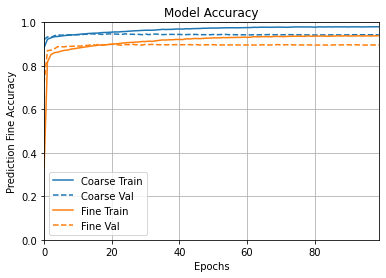

In [18]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

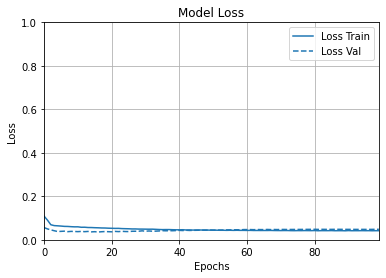

In [19]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [20]:
final_model = keras.Model(model.inputs[:1], model.output)

final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : model_params['loss_function'],
                          'prediction_coarse' : model_params['loss_function']},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

588/588 [==============================] - 10s 15ms/step - loss: 0.0481 - prediction_coarse_loss: 0.0442 - prediction_fine_loss: 0.0790 - prediction_coarse_accuracy: 0.9424 - prediction_fine_accuracy: 0.8958
1. loss ==> 0.04812205955386162
2. prediction_coarse_loss ==> 0.04415211081504822
3. prediction_fine_loss ==> 0.07903572916984558
4. prediction_coarse_accuracy ==> 0.9424468278884888
5. prediction_fine_accuracy ==> 0.895797848701477
588/588 [==============================] - 6s 10ms/step


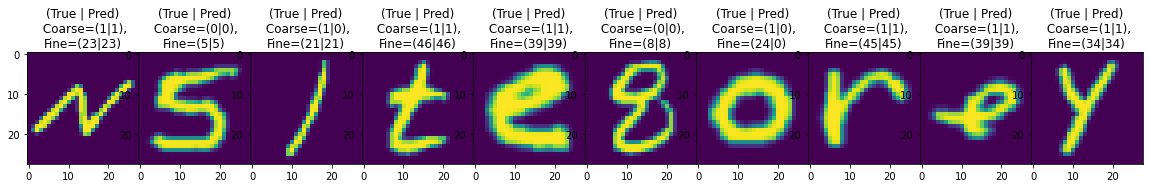

In [21]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 3430   570]
 [  512 14288]]

  • FINE LEVEL 
[[262   0   0 ...   0   0   0]
 [  0 235   0 ...   0   0   0]
 [  0   0 364 ...   0   0   0]
 ...
 [  0   0   0 ... 264   0   0]
 [  0   0   0 ...   0 377   1]
 [  0   0   0 ...   0   2 372]]

  • Classification Report 


  • COARSE LEVEL 


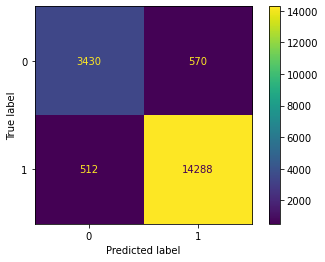

              precision    recall  f1-score   support

           0    0.87012   0.85750   0.86376      4000
           1    0.96164   0.96541   0.96352     14800

    accuracy                        0.94245     18800
   macro avg    0.91588   0.91145   0.91364     18800
weighted avg    0.94216   0.94245   0.94229     18800


  • FINE LEVEL 


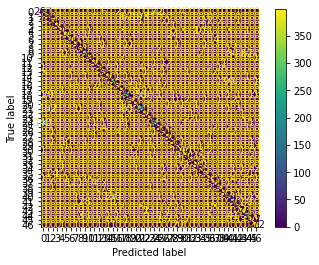

              precision    recall  f1-score   support

           0    0.63133   0.65500   0.64294       400
           1    0.56355   0.58750   0.57528       400
           2    0.92386   0.91000   0.91688       400
           3    0.99749   0.99250   0.99499       400
           4    0.96915   0.94250   0.95564       400
           5    0.96623   0.93000   0.94777       400
           6    0.94472   0.94000   0.94236       400
           7    0.97525   0.98500   0.98010       400
           8    0.96717   0.95750   0.96231       400
           9    0.73892   0.75000   0.74442       400
          10    0.97543   0.99250   0.98389       400
          11    0.97525   0.98500   0.98010       400
          12    0.95990   0.95750   0.95870       400
          13    0.94763   0.95000   0.94881       400
          14    0.98015   0.98750   0.98381       400
          15    0.69104   0.73250   0.71117       400
          16    0.93029   0.96750   0.94853       400
          17    0.97297   0

In [22]:
true_label = [dataset['y_test_coarse'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1]]
metrics.lvl_wise_metric(true_label,pred_label)

In [23]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.919264184397163 
Hierarchical Recall = 0.9211170212765958 
Hierarchical F1-Score = 0.9200053191489361 
Consistency =  0.9927659574468085 
Exact Match =  0.8919148936170213
